## Импорты

In [150]:
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score as accuracy, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [127]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 42

## Загрузка датасета

In [128]:
airlines = pd.read_csv("/content/drive/MyDrive/Университет/NLP/pz1-torch_classification/delay-classification.csv")

Содержимое датасета

In [129]:
airlines.head(7)

,Airline_1,Airline_2,Airline_3,Airline_4,Flight,Time,Length,Delay
0,0.0,1.0,1.0,0.0,0.081669,0.895731,0.135878,1
1,1.0,0.0,0.0,0.0,0.087558,0.913226,0.464122,0
2,1.0,1.0,0.0,1.0,0.062596,0.528341,0.106870,0
3,1.0,1.0,0.0,1.0,0.079621,0.748775,0.181679,0
4,1.0,0.0,0.0,1.0,0.374296,0.593422,0.305344,0
5,0.0,1.0,0.0,0.0,0.188684,0.612316,0.244275,0
6,0.0,0.0,1.0,1.0,0.826805,0.329601,0.112977,0


Размер датасета


In [130]:
airlines.shape

(173782, 8)

Разделение данных на x и y

In [131]:
y, x = airlines["Delay"].values.reshape(-1, 1), airlines.drop("Delay", axis=1).values
y.shape, x.shape

((173782, 1), (173782, 7))

In [132]:
def one_hot(indx, shape: int):
    vector = np.zeros(shape)
    vector[indx] = 1
    return vector

Изменение метки класса в y на one hot вектор с единицей в нужном индексе класса

In [133]:
y = np.apply_along_axis(one_hot, axis=1, arr=y, shape=np.unique(y).shape[0])
y.shape

(173782, 2)

Разделение данных на тренировочную и тестовую выборку

In [134]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15, random_state=random_state)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((147714, 7), (26068, 7), (147714, 2), (26068, 2))

Превращение в тензоры


In [135]:
xtrain = torch.tensor(xtrain, dtype=torch.float16, device=device)
ytrain = torch.tensor(ytrain, dtype=torch.float16, device=device)
xtest = torch.tensor(xtest, dtype=torch.float16, device=device)
ytest = torch.tensor(ytest, dtype=torch.float16, device=device)

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

(torch.Size([147714, 7]),
 torch.Size([147714, 2]),
 torch.Size([26068, 7]),
 torch.Size([26068, 2]))

Создание объектов DataLoader

In [136]:
train_dataset = TensorDataset(xtrain, ytrain)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)

## Создание модели

In [138]:
class Net(nn.Module):
    def __init__(self, layer1_in: int, layer1_out: int, layer2_out: int,
                 layer3_out: int, layer_last_out: int
        ) -> None:
        super(Net, self).__init__()
        self.layer1 = nn.Linear(layer1_in, layer1_out, dtype=torch.float16, device=device)
        self.layer2 = nn.Linear(layer1_out, layer2_out, dtype=torch.float16, device=device)
        self.layer3 = nn.Linear(layer2_out, layer3_out, dtype=torch.float16, device=device)
        self.layer_last = nn.Linear(layer3_out, layer_last_out, dtype=torch.float16, device=device)

    def forward(self, X: torch.Tensor) -> None:
        relu, softmax = nn.ReLU(), nn.Softmax(dim=-1)
        y = self.layer1(X)
        y = relu(y)
        y = self.layer2(y)
        y = relu(y)
        y = self.layer3(y)
        y = relu(y)
        y = self.layer_last(y)
        y = softmax(y)
        return y


In [142]:
def fit(model: nn.Module, dataloader: DataLoader, loss, optimizer, scheduler,
        n_epoh: int = 100
    ) -> list[float]:
    loss_values = []
    for _ in tqdm(range(n_epoh), desc="Epoh"):
        for xbatch, ybatch in tqdm(dataloader, desc="Batch", leave=False):
            optimizer.zero_grad()
            predict = model(xbatch)
            loss_value = loss(ybatch, predict)
            loss_value.backward()
            optimizer.step()
            scheduler.step()
        loss_values.append(loss_value.item())
    return loss_values

In [143]:
model = Net(
    layer1_in=xtrain.shape[1],
    layer1_out=20,
    layer2_out=20,
    layer3_out=10,
    layer_last_out=2
)

for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_uniform_(param, gain=nn.init.calculate_gain('relu'))

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print(model)

Net(
  (layer1): Linear(in_features=7, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=10, bias=True)
  (layer_last): Linear(in_features=10, out_features=2, bias=True)
)


In [ ]:
loss_values = fit(model, train_dataloader, loss, optimizer, scheduler, n_epoh=100)

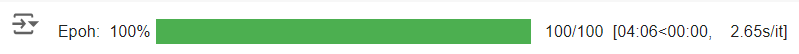

## График уменьшения функции потерь

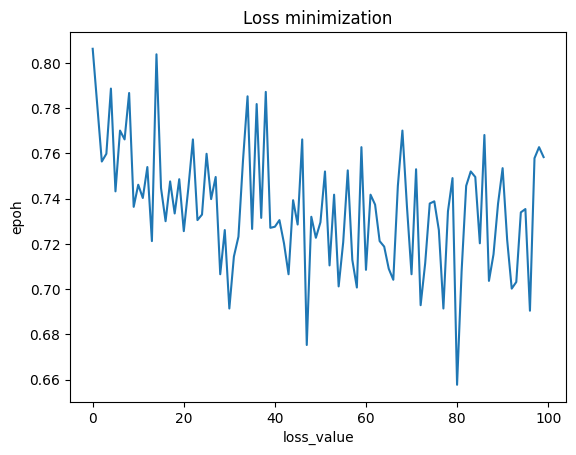

In [147]:
plt.title("Loss minimization")
plt.xlabel("loss_value")
plt.ylabel("epoh")
plt.plot(loss_values);

## Оценка модели

In [158]:
predict = model(xtest).max(axis=1).indices.cpu()
predict.shape

torch.Size([26068])

In [161]:
ytest = ytest.max(axis=1).indices.cpu()
ytest.shape

torch.Size([26068])

In [162]:
confusion_matrix(ytest, predict)

array([[9896, 3203],
       [7376, 5593]])

In [165]:
round(accuracy(ytest, predict), 3)

0.594